## **Import Libraries**

In [ ]:
# %pip install mlxtend --upgrade
# %pip install pyLDAvis
import math
import pandas as pd 
import numpy as np
from numpy import concatenate
import re
from urllib import request
from pprint import pprint 

# Sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import ShuffleSplit
from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from sklearn.utils import shuffle
from sklearn.cluster import KMeans 
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.decomposition  import PCA
from sklearn.metrics import cohen_kappa_score
from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation as LDA

import scipy.cluster.hierarchy as shc
from scipy.sparse import csr_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# nltk 
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Ginsim
import gensim
import gensim.corpora as corpora
import gensim.utils as simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Word2Vec
import gensim.downloader as api
import spacy
import scipy

# Plotting tools
#import pyLDAvis
#import pyLDAvis.gensim_models as genisvis
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer
%matplotlib inline

In [ ]:
nltk.download("stopwords")
nltk.download("wordnet")
print(stopwords.words('english'))
import nltk
nltk.download('punkt')

## **Preprocessing**

In [ ]:
def removes_stopwords(texts):
  stop_words = stopwords.words('english')
  return [word for word in gensim.utils.simple_preprocess(str(texts)) if word not in stop_words]


def make_bigrams(texts):
    bigram = gensim.models.Phrases(texts, min_count = 5, threshold = 100)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    bigram = gensim.models.Phrases(texts, min_count = 5, threshold = 100)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram = gensim.models.Phrases(bigram[texts], threshold = 100)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    return [trigram_mod[bigram_mod[doc]] for doc in texts]    

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
#  1- Politics Title: Democracy In America   Author: Alexis de Toqueville
url1 = "https://www.gutenberg.org/cache/epub/815/pg815.txt" 
#  2- Law  Title: The Common Law  Author: Edward Gibbon
url2 = "https://www.gutenberg.org/cache/epub/2449/pg2449.txt"   
#  3- Music   Title: The Lighter Classics in Music   Author: David Ewen
url3 = "https://www.gutenberg.org/cache/epub/66346/pg66346.txt"   
#  4- Food     Title: Food and Flavor    Author: Henry Theophilus
url4 = "https://www.gutenberg.org/files/61719/61719-0.txt"   
#  5- Computer and Tech  Title: The Jargon File  Author:  Various
url5 = "https://www.gutenberg.org/cache/epub/38/pg38.txt"       

urls = [url1 ,url2 ,url3, url4 ,url5]

Books_names = ["Democracy In America" ,
               "The Common Law" ,
               "The Lighter Classics in Music"  ,
               "Food and Flavor" ,
               "The Jargon File"]

# Books_label_num = [ '0' ,'1' ,'2', '3' ,'4']
Books_label = ['a', 'b', 'c', 'd', 'e']

Authors = ["Alexis de Toqueville" ,
           "Oliver Wendell Holmes" ,
           "David Ewen" ,
           "Henry Theophilus" ,
           "Various"]

book = []
r = []
bg = []

for U  in urls :
  response = request.urlopen(U)
  raw = response.read().decode('utf8')
  text= re.findall(r"[a-zA-Z]{3,}", raw)
  r.append(removes_stopwords(text))
bi_grams = make_bigrams(r)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
data_lemmatized = lemmatization(bi_grams,
                                allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
texts = data_lemmatized

# make sure that all lists contain 100 word 
Books_contents_100 = []               
for i in texts:
    l = i[0:(math.floor(len(i)/150)) * 150]
    Books_contents_100.append(l)

# combine all lists in one dataframe 
data = pd.DataFrame()
for i in range(len(Books_contents_100)):
    dic = {}
    lis =  [Books_contents_100[i][x:x+150] for x in range(0, len(Books_contents_100[i]), 150)]
    dic['index']= i  # refer to the number of the book 
    dic['Authors']= Authors[i]
    dic['title']= Books_names[i] # refer to the book name
    dic['label'] = Books_label[i]
    dic['a150_Words'] = lis # the partition of 100 words
    df_0 = pd.DataFrame(dic)
    for i in range(len(df_0)):
        df_0["a150_Words"][i] = " ".join(df_0["a150_Words"][i])
    df = df_0[:200]
    data = data.append(df)
    
data = shuffle(data)


In [ ]:
data.head()           


,index,Authors,title,label,a150_Words
172,0,Alexis de Toqueville,Democracy In America,a,politic descend humblest class society never s...
89,0,Alexis de Toqueville,Democracy In America,a,cessation contest disappear rapidly raise abse...
109,2,David Ewen,The Lighter Classics in Music,c,concert work make skilful blend serious popula...
18,1,Oliver Wendell Holmes,The Common Law,b,kill fall house manner thing motion death shal...
56,2,David Ewen,The Lighter Classics in Music,c,influence prove far great music write many ope...


In [ ]:
da = data.iloc[109, 4]
len(da.split())

150

## **Text Transformation**

### (1) Bag of Words

In [ ]:
count_Vec= CountVectorizer()
bow = count_Vec.fit_transform(data['a150_Words'])
X_bow = bow.toarray()
bow_df = pd.DataFrame(bow.toarray(), columns=count_Vec.get_feature_names())
bow_df

,abandon,abandoning,abash,abbess,abbreviate,abbreviation,abdicate,abduct,abend,abeyance,abhor,ability,abject,able,ably,abnormal,abode,abolish,abolishe,abolition,abominable,aboriginal,abort,abound,abridge,abroad,abrupt,abruptly,absence,absent,absolute,absolutely,absolution,absorb,absorption,absque,abstain,abstract,abstraction,absurd,...,xylophone,yaba,yard,year,year_book,yearly,yearn,years_ago,yeat,yellow,yellowish,yesterday,yesterthought,yet,yiddish,yield,yoke,yolk,yoo,young,youth,youthful,yradi,yucky,yuppie,yyyy,zeal,zealot,zealous,zealously,zed,zee,zeltube,zephyr,zeroth,zigeunerkind,zion,zip,zoo,zwieback
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### (2) TFIDF

In [ ]:
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(data['a150_Words'])
X_tfidf = tfidf.toarray()
tfidf_df = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names())
tfidf_df

,abandon,abandoning,abash,abbess,abbreviate,abbreviation,abdicate,abduct,abend,abeyance,abhor,ability,abject,able,ably,abnormal,abode,abolish,abolishe,abolition,abominable,aboriginal,abort,abound,abridge,abroad,abrupt,abruptly,absence,absent,absolute,absolutely,absolution,absorb,absorption,absque,abstain,abstract,abstraction,absurd,...,xylophone,yaba,yard,year,year_book,yearly,yearn,years_ago,yeat,yellow,yellowish,yesterday,yesterthought,yet,yiddish,yield,yoke,yolk,yoo,young,youth,youthful,yradi,yucky,yuppie,yyyy,zeal,zealot,zealous,zealously,zed,zee,zeltube,zephyr,zeroth,zigeunerkind,zion,zip,zoo,zwieback
0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.076262,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.084946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.060717,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.038051,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.067546,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.078520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00

### (3) Word2Vec

In [ ]:
# split our partitions to list of words
sent = data['a150_Words'].tolist()
splitted_sent = [sen.split() for sen in sent]
print(len(splitted_sent))

1000


In [ ]:
# load a pre-trained word2vec-google model
#wv = api.load('word2vec-google-news-300')

In [ ]:
# build our word2vec model
word_2_vec_model = Word2Vec(splitted_sent,
                            min_count= 1,
                            size= 150,
                            workers=6, 
                            window= 3,
                            sg= 1)
# save trained model
word_2_vec_model.save("word2vec.model")

In [ ]:
def vectorize(list_of_docs, model):
    """Generate vectors for list of documents using a Word Embedding
    
    Args:
        list_of_docs: List of documents
        model: Gensim's Word Embedding

    Returns:
        List of document vectors
    """
    features = []

    for tokens in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features
    
vectorized_docs = vectorize(splitted_sent, model=word_2_vec_model)
X_emb = np.array(vectorized_docs)
len(vectorized_docs), len(vectorized_docs[0])

(1000, 150)

### (4) LDA

In [ ]:
# create dictionary
dictionary = corpora.Dictionary(data['a150_Words'].str.split())
#Term document frequency
corpus = [dictionary.doc2bow(text) for text in data['a150_Words'].str.split()]

# 50 Topic
lda_model_50 = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = dictionary,
                                           num_topics = 150,
                                           random_state = 100,
                                           update_every = 1,
                                           chunksize = 100, 
                                           passes = 10, 
                                           alpha = 'auto',
                                           per_word_topics = True)
pred_50 = lda_model_50.inference(corpus)

## **Models**

### **(1) K-Means**

In [ ]:
def build_kMeans(clusters, X_data):
  kmeans_model= KMeans(n_clusters= clusters, init='k-means++', random_state=0)
  y_pred = kmeans_model.fit_predict(X_data)
  return kmeans_model, y_pred

#### (1.1) K-means With BOW

In [ ]:
bow_kmeans, bow_kmeans_pred = build_kMeans(5,X_bow)

#### (1.2) K-Means with TFIDF

In [ ]:
tfidf_kmeans, tfidf_kmeans_pred = build_kMeans(5,X_tfidf)

#### (1.3) K-Means with Word2Vec

In [ ]:
emb_kmeans, emb_kmeans_pred = build_kMeans(5,X_emb)

#### (1.4) K-Means with LDA

In [ ]:
lda_kmeans, lda_kmeans_pred = build_kMeans(5, pred_50[0])

### **(2) Expectation Maximaziation (EM)**

In [ ]:
def build_em(clusters, X_data):
  pca = PCA(n_components= 0.99)
  new_X = pca.fit_transform(X_data)
  print("shape before using PCA : ",X_data.shape)
  print("shape after using PCA : ",new_X.shape)
  print(f'the new dimension consists of {new_X.shape[1]} that represent 99% of data info '.format(new_X.shape[1]))
  
  gmm_model= GaussianMixture(n_components=clusters ,
                             covariance_type= "spherical" ,
                             n_init= 10 )
  
  y_pred= gmm_model.fit_predict(new_X)
  gmm_probability = gmm_model.predict_proba(new_X)
  return gmm_model, y_pred, gmm_probability 

#### (2.1) EM with BOW

In [ ]:
bow_em, bow_em_pred, bow_em_proba = build_em(5,X_bow)

shape before using PCA :  (1000, 13496)
shape after using PCA :  (1000, 940)
the new dimension consists of 940 that represent 99% of data info 


#### (2.2) EM With TFIDF

In [ ]:
tfidf_em, tfidf_em_pred, tfidf_em_proba = build_em(5,X_tfidf)

shape before using PCA :  (1000, 13496)
shape after using PCA :  (1000, 964)
the new dimension consists of 964 that represent 99% of data info 


#### (2.3) EM with Word2Vec

In [ ]:
emb_em, emb_em_pred, emb_em_proba = build_em(5,X_emb)

shape before using PCA :  (1000, 150)
shape after using PCA :  (1000, 4)
the new dimension consists of 4 that represent 99% of data info 


#### (2.4) EM with LDA

In [ ]:
lda_em, lda_em_pred, lda_em_proba = build_em(5, pred_50[0])

shape before using PCA :  (1000, 150)
shape after using PCA :  (1000, 71)
the new dimension consists of 71 that represent 99% of data info 


### **(3) Hierarchical clustering (Agglomerative)**

In [ ]:
def build_hierarchical_cluster(clusters, X_data, title):
  # plot dendogram
  plt.figure(figsize=(10, 7))  
  plt.title(title) 

  dend= shc.dendrogram(shc.linkage(X_data, method='ward'))
  agg_model= AgglomerativeClustering(n_clusters=clusters, affinity='euclidean', linkage='ward')  
  y_pred= agg_model.fit_predict(X_data)
  return agg_model, y_pred

#### (3.1) Hierarchical clustering With BOW

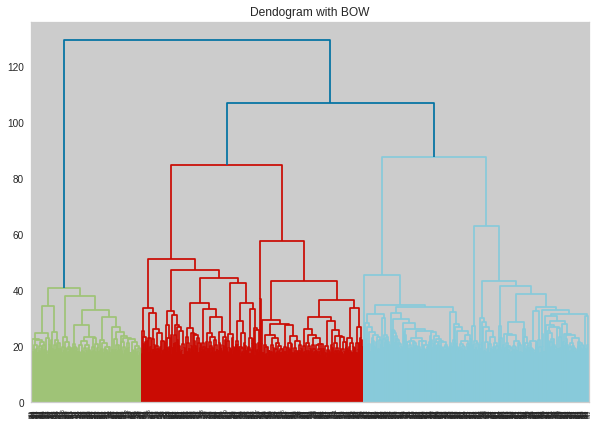

In [ ]:
bow_agg, bow_agg_pred= build_hierarchical_cluster(5,X_bow,"Dendogram with BOW")

#### (3.2) Hierarchical clustering With TFIDF

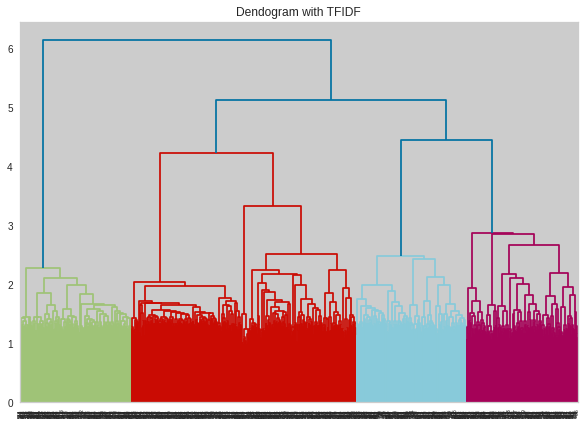

In [ ]:
tfidf_agg, tfidf_agg_pred= build_hierarchical_cluster(5,X_tfidf,"Dendogram with TFIDF")

#### (3.3) Hierarchical clustering With Word2Vec

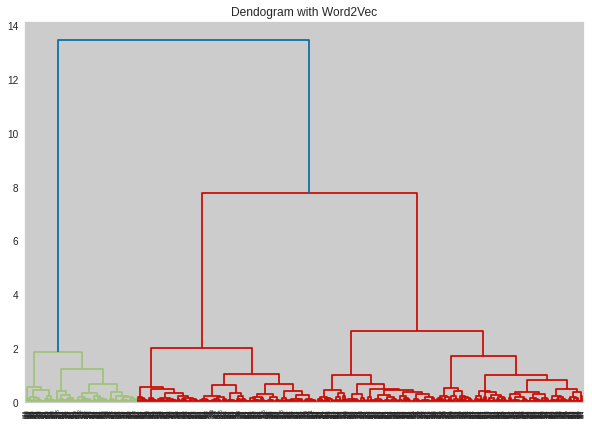

In [ ]:
emb_agg, emb_agg_pred= build_hierarchical_cluster(5,X_emb,"Dendogram with Word2Vec")

#### (3.4) Hierarchical clustering With LDA

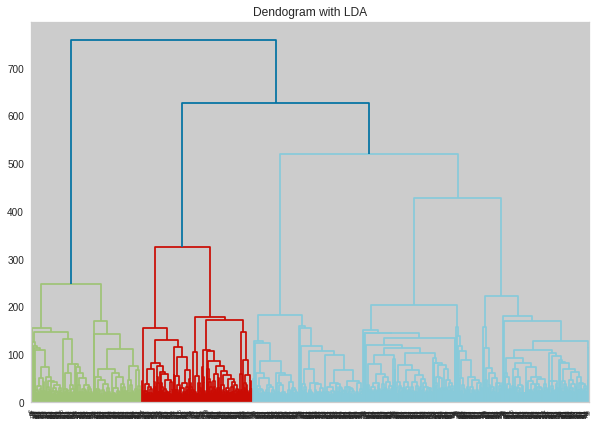

In [ ]:
lda_agg, lda_agg_pred= build_hierarchical_cluster(5,pred_50[0],"Dendogram with LDA")

## **Evaluation**

### **(1) Kapaa**

#### (1.1) Kappa with K-means

In [ ]:
print("Kappa Score of K-means With BOW           :  {:.4f}".format(cohen_kappa_score(data['index'],bow_kmeans_pred)))
print("Kappa Score of K-means With TFIDF         :  {:.4f}".format(cohen_kappa_score(data['index'],tfidf_kmeans_pred)))
print("Kappa Score of K-means With Word2Vec      :  {:.4f}".format(cohen_kappa_score(data['index'],emb_kmeans_pred)))
print("Kappa Score of K-means With LDA           :  {:.4f}".format(cohen_kappa_score(data['index'],lda_kmeans_pred)))

Kappa Score of K-means With BOW           :  0.0075
Kappa Score of K-means With TFIDF         :  -0.2475
Kappa Score of K-means With Word2Vec      :  0.4637
Kappa Score of K-means With LDA           :  -0.2450


#### (1.2) Kappa with EM

In [ ]:
print("Kappa Score of EM With BOW                :  {:.4f}".format(cohen_kappa_score(data['index'],bow_em_pred)))
print("Kappa Score of EM With TFIDF              :  {:.4f}".format(cohen_kappa_score(data['index'],tfidf_em_pred)))
print("Kappa Score of EM With Word2Vec           :  {:.4f}".format(cohen_kappa_score(data['index'],emb_em_pred)))
print("Kappa Score of EM With LDA                :  {:.4f}".format(cohen_kappa_score(data['index'],lda_em_pred)))

Kappa Score of EM With BOW                :  -0.2500
Kappa Score of EM With TFIDF              :  -0.0012
Kappa Score of EM With Word2Vec           :  -0.2450
Kappa Score of EM With LDA                :  0.2375


#### (1.3) Kappa with Hierarchical clustering

In [ ]:
print("Kappa Score of Hierarchical clustering With BOW                :  {:.4f}".format(cohen_kappa_score(data['index'],bow_agg_pred)))
print("Kappa Score of Hierarchical clustering With TFIDF              :  {:.4f}".format(cohen_kappa_score(data['index'],tfidf_agg_pred)))
print("Kappa Score of Hierarchical clustering With Word2Vec           :  {:.4f}".format(cohen_kappa_score(data['index'],emb_agg_pred)))
print("Kappa Score of Hierarchical clustering With LDA                :  {:.4f}".format(cohen_kappa_score(data['index'],lda_agg_pred)))

Kappa Score of Hierarchical clustering With BOW                :  0.2450
Kappa Score of Hierarchical clustering With TFIDF              :  0.0038
Kappa Score of Hierarchical clustering With Word2Vec           :  -0.1100
Kappa Score of Hierarchical clustering With LDA                :  -0.2400


### **(2) Silhouette**

In [ ]:
def visualize_silhouette_kmeans(X_data, model, title):
  # Instantiate the clustering model and visualizer
  visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
  # Fit the data to the visualizer
  visualizer.fit(X_data)
  plt.title("Silhouette Score of K-means With " + title)

#### (2.1) Silhouette with K-means

In [ ]:
print("Silhouette Score of K-means With BOW      :  {:.4f}".format(silhouette_score(X_bow,bow_kmeans_pred)))
print("Silhouette Score of K-means With TFIDF    :  {:.4f}".format(silhouette_score(X_tfidf,tfidf_kmeans_pred)))
print("Silhouette Score of K-means With Word2Vec :  {:.4f}".format(silhouette_score(X_emb,emb_kmeans_pred)))
print("Silhouette Score of K-means With LDA      :  {:.4f}".format(silhouette_score(pred_50[0],lda_kmeans_pred)))

Silhouette Score of K-means With BOW      :  0.0375
Silhouette Score of K-means With TFIDF    :  0.0262
Silhouette Score of K-means With Word2Vec :  0.4568
Silhouette Score of K-means With LDA      :  0.2547


#### Silhouette with K-means and BOW

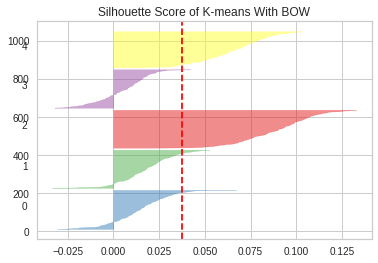

In [ ]:
visualize_silhouette_kmeans(X_bow,bow_kmeans,"BOW");

#### Silhouette with K-means and TFIDF

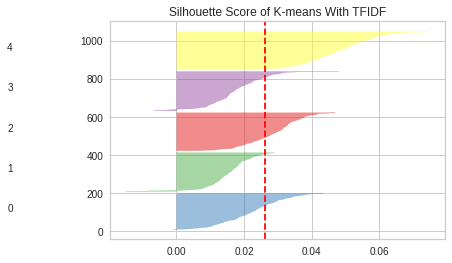

In [ ]:
visualize_silhouette_kmeans(X_tfidf,tfidf_kmeans, "TFIDF");

#### Silhouette with K-means and word embedding

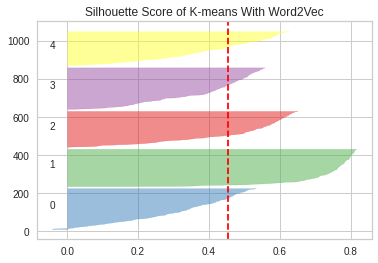

In [ ]:
visualize_silhouette_kmeans(X_emb,emb_kmeans, "Word2Vec");

#### Silhouette with K-means and LDA

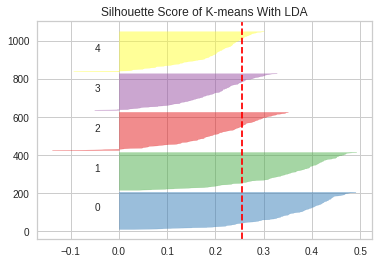

In [ ]:
visualize_silhouette_kmeans(pred_50[0],lda_kmeans,"LDA");

#### (2.2) Silhouette with EM

In [ ]:
print("Silhouette Score of EM With BOW      :  {:.4f}".format(silhouette_score(X_bow,bow_em_pred)))
print("Silhouette Score of EM With TFIDF    :  {:.4f}".format(silhouette_score(X_tfidf,tfidf_em_pred)))
print("Silhouette Score of EM With Word2Vec :  {:.4f}".format(silhouette_score(X_emb,emb_em_pred)))
print("Silhouette Score of EM With LDA      :  {:.4f}".format(silhouette_score(pred_50[0],lda_em_pred)))

Silhouette Score of EM With BOW      :  0.0293
Silhouette Score of EM With TFIDF    :  0.0262
Silhouette Score of EM With Word2Vec :  0.4481
Silhouette Score of EM With LDA      :  0.1859


#### (2.3) Silhouette with Hierarchical clustering

In [ ]:
print("Silhouette Score of Hierarchical clustering With BOW      :  {:.4f}".format(silhouette_score(X_bow,bow_agg_pred)))
print("Silhouette Score of Hierarchical clustering With TFIDF    :  {:.4f}".format(silhouette_score(X_tfidf,tfidf_agg_pred)))
print("Silhouette Score of Hierarchical clustering With Word2Vec :  {:.4f}".format(silhouette_score(X_emb,emb_agg_pred)))
print("Silhouette Score of Hierarchical clustering With LDA      :  {:.4f}".format(silhouette_score(pred_50[0],lda_agg_pred)))

Silhouette Score of Hierarchical clustering With BOW      :  0.0374
Silhouette Score of Hierarchical clustering With TFIDF    :  0.0261
Silhouette Score of Hierarchical clustering With Word2Vec :  0.4104
Silhouette Score of Hierarchical clustering With LDA      :  0.2565


### **(4) Coherence With LDA**

In [ ]:
cm = CoherenceModel(model= lda_model_50, corpus= corpus, coherence='u_mass')
coherence = cm.get_coherence()  # get coherence value
coherence

-7.013584511676512

## **Visualization**

### Word Cloud of each Document


 The most frequent 50 words of book: The Jargon File



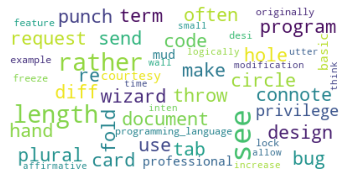


 The most frequent 50 words of book: The Lighter Classics in Music



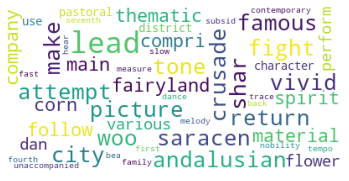


 The most frequent 50 words of book: Democracy In America



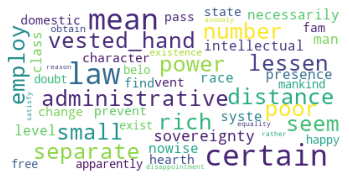


 The most frequent 50 words of book: Food and Flavor



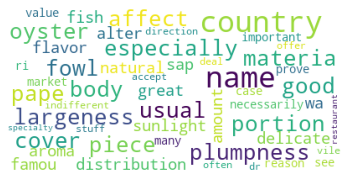


 The most frequent 50 words of book: The Common Law



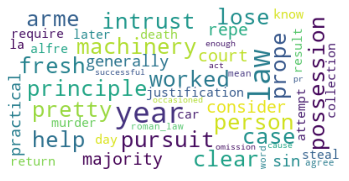

In [ ]:
# plot word cloud for the most frequent 50 words in each book  
import wordcloud

for label in data['title'].unique():
  books = data[data["title"]==label]["a150_Words"]

  #wordcloud 
  print(f"\n The most frequent 50 words of book: {label}\n")
  wc = wordcloud.WordCloud(background_color='white', max_words=50, 
                          max_font_size=35)
  wc = wc.generate(str(books))
  plt.axis('off')
  plt.imshow(wc, cmap=None)
  plt.show()

### (2) Visualize Predicted Clusters

In [ ]:
def visualize_cluster(cluster_model, data, y_pred, em=True):
  # get centroids of kmeans cluster
  if em:
    centroids = np.empty(shape=(cluster_model.n_components, data.shape[1]))
  else:
    centroids = cluster_model.cluster_centers_

  # we want to transform the rows and the centroids
  # todense return matrix
  all_Data = concatenate((data.todense(), centroids))

  ### define parameters
  n_clusters = 5
  # Initialization of embedding could also be 'random' {‘random’, ‘pca’}
  tsne_init = "pca"
  # the number of nearest neighbors that is used in
  # other manifold learning algorithms.
  tsne_perplexity = 30.0
  # Controls how tight natural clusters in the original space are
  # in the embedded space and how much space will be between them
  tsne_early_exaggeration = 4.0

  tsne_learning_rate = 10

  # Build TSNE model
  tsne_model = TSNE(n_components= 2,   # Dimension of the embedded space.
                    random_state= 0,  
                    init= tsne_init,
                    perplexity= tsne_perplexity,
                    early_exaggeration= tsne_early_exaggeration,
                    learning_rate= tsne_learning_rate)

  transformed_labeled_Data = tsne_model.fit_transform(all_Data)
  # print(transformed_labeled_Data)
  plt.scatter(transformed_labeled_Data[:-n_clusters, 0], transformed_labeled_Data[:-n_clusters, 1], c=y_pred, cmap=plt.cm.Paired, marker= 'x')
  plt.scatter(transformed_labeled_Data[-n_clusters:, 0], transformed_labeled_Data[-n_clusters:, 1], marker= 'o')
  plt.legend("off")
  plt.show()

#### (2.1) K-Means With BOW

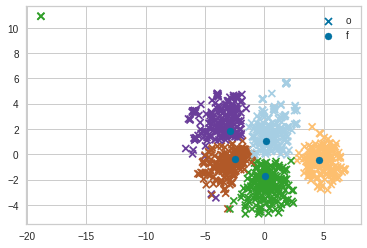

In [ ]:
visualize_cluster(bow_kmeans, bow, bow_kmeans_pred,False)

#### (2.2) K-Means With TFIDF

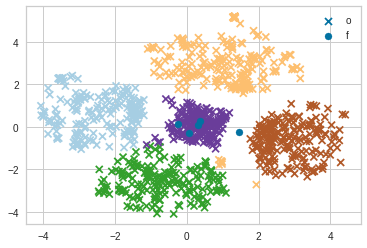

In [ ]:
visualize_cluster(tfidf_kmeans, tfidf, tfidf_kmeans_pred,False)

#### (2.3) K-Means With Word2Vec

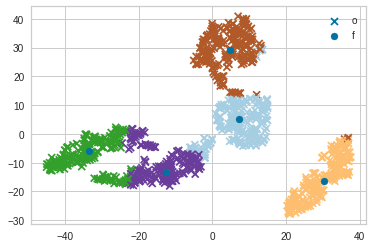

In [ ]:
x_emb_matrix = csr_matrix(X_emb)
visualize_cluster(emb_kmeans, x_emb_matrix, emb_kmeans_pred,False)

#### (2.4) K-Means With LDA

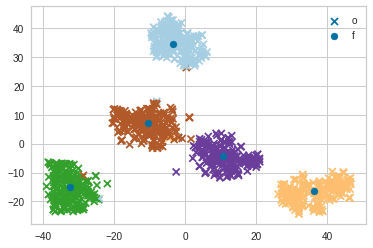

In [ ]:
x_lda_matrix = csr_matrix(pred_50[0])
visualize_cluster(lda_kmeans, x_lda_matrix, lda_kmeans_pred,False)

#### (3.1) EM With BOW

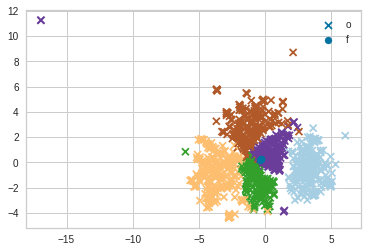

In [ ]:
visualize_cluster(bow_em, bow, bow_em_pred,True)

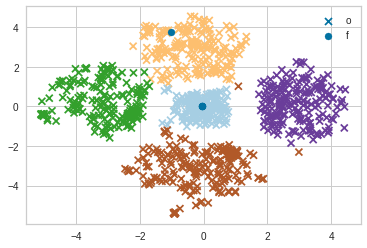

In [ ]:
visualize_cluster(tfidf_em, tfidf ,tfidf_em_pred ,True)

# **`Error Analysis`**



In [ ]:
print("Silhouette Score of K-means With Word2Vec :  {:.4f}".format(silhouette_score(X_emb,emb_kmeans_pred)))


Silhouette Score of K-means With Word2Vec :  0.4568


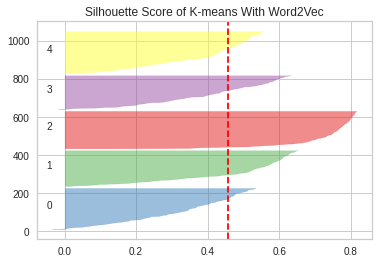

In [ ]:
visualize_silhouette_kmeans(X_emb,emb_kmeans, "Word2Vec");

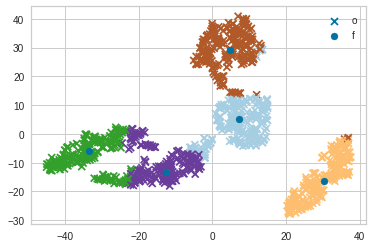

In [ ]:
visualize_cluster(emb_kmeans, x_emb_matrix, emb_kmeans_pred,False)

In [ ]:
# Create  analysis data frame 
def analysis_data (features_eng_results , data):
  analysis_df = data[['a150_Words', 'label' , "index" ]]
  analysis_df['cluster_output'] = pd.DataFrame(features_eng_results.astype(str))
  return analysis_df

In [ ]:
# count the number of matches between most frequent words in clusters and true labels
from collections import Counter

def most_frequent_words(num_words ,df_name , label_column , docu_column):
  genres = []
  for label in df_name[label_column].unique():
    genre = df_name[df_name[label_column]==label][docu_column]
    genres.append(genre)

  clusters_label= []
  for cls in range(len(genres)):
    lab = []
    for doc in genres[cls]:
      text = ""
      text += doc
      text += " "
      lab.append(text)
    clusters_label.append(lab)

  clusters_content = []
  for i in range(len(clusters_label)):
    whole_texts = ""
    for j in range(len(clusters_label[i])):
      whole_texts += clusters_label[i][j]
      whole_texts += " "
    clusters_content.append(whole_texts)

  most_frequent_words = []
  most_frequent_words_weights = []

  for ele in range(len(clusters_content)):
    word_list =[]
    weights_list = []
    string = clusters_content[ele]
    split_it = string.split()                # Pass the split_it list to instance of Counter class.
    Count = Counter(split_it)              # most_common() produces k frequently encountered input values and their respective counts.
    most_occur = Count.most_common(num_words)
    for tup in range(len(most_occur)): 
      fw =  most_occur[tup][0]
      weights = most_occur[tup][1]
      word_list.append(fw)
      weights_list.append(weights)

    most_frequent_words.append(word_list)
    most_frequent_words_weights.append(weights_list)

  return most_frequent_words , most_frequent_words_weights

In [ ]:
# Create  disctionary of matches 
def matches_dict(labels_mf , clusters_label_mf):
  lab_cls_match = {}
  for i in range(len(labels_mf)):
    scores_i = []
    for j in range(len(clusters_mf)):
      matches = len(set(labels_mf[i]) & set(clusters_mf[j]))
      scores_i.append(matches)
    lab_cls_match[i] = scores_i 
  return lab_cls_match

In [ ]:
# Create  disctionary of matches_weights
def weights_dict(labels_mf , clusters_label_mf ,clusters_mfw ):
  lab_cls_match_weights = {}
  for i in range(len(labels_mf)):
    scores_i = []
    for j in range(len(clusters_mfw)):
      matches = len(set(labels_mf[i]) & set(clusters_mf[j]))
      weight = sum(clusters_mfw[j][0:matches])
      scores_i.append(weight)
    lab_cls_match_weights[i] = scores_i 
  return lab_cls_match_weights

In [ ]:
#show list most frequent words and there weights
def most_frequent_words_weights(lbl_list , wgt_list):
  list_most_frequent_words_weights = []
  for i  in range(len(lbl_list)):
    lis = []
    for f, b in zip(lbl_list[i], wgt_list[i]):
      element = [f ,b]
      ele= tuple(element)
      lis.append(ele)
    list_most_frequent_words_weights.append(lis)   
  return list_most_frequent_words_weights

In [ ]:
analysis_df = analysis_data(emb_kmeans_pred , data)
analysis_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,a150_Words,label,index,cluster_output
172,politic descend humblest class society never s...,a,0,2
89,cessation contest disappear rapidly raise abse...,a,0,1
109,concert work make skilful blend serious popula...,c,2,0
18,kill fall house manner thing motion death shal...,b,1,0
56,influence prove far great music write many ope...,c,2,3
...,...,...,...,...
156,perfect better vinegar oil imperfect case find...,d,3,4
118,regulate commercial relation state government ...,a,0,4
114,twentieth part population world bear torch rev...,a,0,1
37,traverse measureless waste full trust protecti...,c,2,0


In [ ]:
labels_mf , labels_mfw  = most_frequent_words (20, analysis_df, "index"  , "a150_Words")
clusters_mf,clusters_mfw = most_frequent_words( 20, analysis_df, "cluster_output", "a150_Words")
lab_cls_match = matches_dict(labels_mf , clusters_mf)
lab_cls_match

{0: [8, 7, 7, 8, 7],
 1: [6, 6, 7, 7, 6],
 2: [10, 9, 9, 8, 10],
 3: [6, 7, 7, 6, 7],
 4: [8, 8, 8, 8, 8]}

In [ ]:
lab_cls_weights = weights_dict(labels_mf , clusters_mf ,clusters_mfw)
lab_cls_weights

{0: [1259, 1191, 1233, 1228, 1124],
 1: [1024, 1055, 1233, 1114, 988],
 2: [1490, 1460, 1504, 1228, 1510],
 3: [1024, 1191, 1233, 984, 1124],
 4: [1259, 1327, 1369, 1228, 1253]}

In [ ]:
frequent_elements_labels = most_frequent_words_weights(labels_mf,labels_mfw)
print("\n Frequent words with its occurancies through the aactual class (label) \n")
print("most frequent words in label : 0  \n ", frequent_elements_labels[0] ,"\n")
print("most frequent words in label : 1  \n ", frequent_elements_labels[1] ,"\n")
print("most frequent words in label : 2  \n ", frequent_elements_labels[2] ,"\n")
print("most frequent words in label : 3  \n ", frequent_elements_labels[3] ,"\n")
print("most frequent words in label : 4  \n ", frequent_elements_labels[4] ,"\n")


 Frequent words with its occurancies through the aactual class (label) 

most frequent words in label : 0  
  [('state', 374), ('law', 334), ('may', 307), ('power', 233), ('government', 221), ('nation', 219), ('people', 205), ('great', 194), ('man', 171), ('political', 154), ('country', 142), ('would', 138), ('time', 128), ('interest', 122), ('right', 121), ('public', 117), ('influence', 117), ('see', 115), ('authority', 110), ('citizen', 109)] 

most frequent words in label : 1  
  [('music', 591), ('first', 419), ('write', 329), ('melody', 301), ('dance', 282), ('work', 242), ('opera', 233), ('composer', 221), ('composition', 217), ('piano', 211), ('come', 209), ('make', 196), ('popular', 189), ('year', 188), ('become', 187), ('song', 185), ('famous', 167), ('also', 156), ('bear', 156), ('die', 144)] 

most frequent words in label : 2  
  [('law', 541), ('case', 409), ('may', 334), ('would', 287), ('man', 265), ('act', 224), ('say', 217), ('defendant', 217), ('fact', 202), ('make', 

In [ ]:
frequent_elements_weights = most_frequent_words_weights(clusters_mf,clusters_mfw)
print("\n Frequent words with its occurancies through the aactual cluster (output) \n")
print("most frequent words in cluster : 0  \n ", frequent_elements_weights[0] ,"\n")
print("most frequent words in cluster : 1  \n ", frequent_elements_weights[1] ,"\n")
print("most frequent words in cluster : 2  \n ", frequent_elements_weights[2] ,"\n")
print("most frequent words in cluster : 3  \n ", frequent_elements_weights[3] ,"\n")
print("most frequent words in cluster : 4  \n ", frequent_elements_weights[4] ,"\n")


 Frequent words with its occurancies through the aactual cluster (output) 

most frequent words in cluster : 0  
  [('make', 213), ('may', 195), ('use', 169), ('law', 160), ('would', 147), ('first', 140), ('also', 118), ('time', 117), ('case', 116), ('see', 115), ('music', 114), ('state', 108), ('man', 108), ('work', 103), ('good', 98), ('act', 91), ('write', 87), ('know', 86), ('great', 85), ('find', 85)] 

most frequent words in cluster : 1  
  [('may', 209), ('law', 207), ('make', 191), ('see', 163), ('use', 148), ('case', 137), ('would', 136), ('also', 136), ('time', 133), ('first', 132), ('say', 123), ('music', 117), ('state', 109), ('give', 103), ('work', 100), ('man', 90), ('take', 89), ('write', 89), ('know', 88), ('thing', 87)] 

most frequent words in cluster : 2  
  [('make', 215), ('may', 214), ('use', 200), ('law', 177), ('first', 149), ('see', 141), ('would', 137), ('write', 136), ('also', 135), ('time', 128), ('case', 123), ('good', 115), ('man', 111), ('take', 109), ('